##  PROJET: Détection de Spam SMS avec Réduction de Dimensionalité


OBJECTIFS:
1. Prétraiter et nettoyer des SMS (ham/spam)
2. Vectoriser avec TF-IDF
3. Réduire la dimensionalité avec un Autoencodeur
4. Comparer le modèle avec et sans sélection de caractéristiques
5. Utiliser la Cross-Validation pour une évaluation robuste
6. Utilisation d'un modele pré entrainé (Bert)

In [4]:
# importation des bibliotheques

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, make_scorer, mean_squared_error
)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,Dropout
from tensorflow.keras.optimizers import Adam

# Pour BERT avec TensorFlow
# from transformers import AutoTokenizer, TFAutoModel


2025-12-10 14:36:22.817327: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

1. Prétraiter et nettoyer des SMS (ham/spam)

In [6]:
df = pd.read_csv("SMSSpamCollection", sep="\t", header=None, names=["label", "text"])

print(f" Dataset chargé: {df.shape[0]} messages")
print(f"  - Ham (légitimes): {(df['label'] == 'ham').sum()} ({(df['label'] == 'ham').sum()/len(df)*100:.1f}%)")
print(f"  - Spam: {(df['label'] == 'spam').sum()} ({(df['label'] == 'spam').sum()/len(df)*100:.1f}%)")


 Dataset chargé: 5572 messages
  - Ham (légitimes): 4825 (86.6%)
  - Spam: 747 (13.4%)


In [7]:
english_stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    """
    Nettoie et normalise le texte:
    1. Conversion en minuscules
    2. Suppression des caractères non-alphabétiques
    3. Suppression des stopwords
    4. Stemming
    """
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    tokens = text.split()
    tokens = [stemmer.stem(t) for t in tokens if t not in english_stopwords]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(preprocess_text)
df_clean_export = df[["label", "clean_text"]].copy()
df_clean_export.to_csv("sms_clean.csv", index=False)

print("✓ Textes nettoyés et exportés vers 'sms_clean.csv'")

✓ Textes nettoyés et exportés vers 'sms_clean.csv'


2. Vectoriser avec TF-IDF

In [9]:
# SÉPARATION TRAIN/TEST ET VECTORISATION TF-IDF

X = df["clean_text"].values
y = df["label"].values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

print(f" Vectorisation complétée")
print(f"  - Dimensions train: {X_train_tfidf.shape}")
print(f"  - Dimensions test: {X_test_tfidf.shape}")

# Conversion pour l'autoencodeur
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()


 Vectorisation complétée
  - Dimensions train: (4457, 5000)
  - Dimensions test: (1115, 5000)


3. Réduire la dimensionalité avec un Autoencodeur

In [11]:
# Définition de l'autoencodeur (réduction de dimension)

# Dimension d'entrée (nb de features TF-IDF)
input_dim = X_train_dense.shape[1]

# Couche d'entrée
input_layer = Input(shape=(input_dim,), name="input_layer")

# Encodeur : input_dim -> 256 -> 128
encoder_hidden = Dense(256, activation='relu', name="encoder_hidden")(input_layer)
latent_space = Dense(128, activation='relu', name="latent_space")(encoder_hidden)

# Décodeur : 128 -> 256 -> input_dim
decoder_hidden = Dense(256, activation='relu', name="decoder_hidden")(latent_space)
output_layer = Dense(input_dim, activation='sigmoid', name="output_layer")(decoder_hidden)

# Modèle autoencodeur complet (X -> Z -> X_hat)
autoencoder = Model(inputs=input_layer, outputs=output_layer, name="autoencoder_sms")

# Modèle encodeur seul (X -> Z)
encoder = Model(inputs=input_layer, outputs=latent_space, name="encoder_sms")

print("\nRésumé de l'autoencodeur :")
autoencoder.summary()



Résumé de l'autoencodeur :


Model: "autoencoder_sms"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_hidden (Dense)          │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_hidden (Dense)          │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5000)           │     1,285,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,631,176 (10.04 MB)

 Trainable params: 2,631,176 (10.04 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compilation et entraînement de l'autoencodeur (MSE)

autoencoder.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mse')
history = autoencoder.fit(
    X_train_dense, X_train_dense,
    epochs=5,
    batch_size=256,
    validation_split=0.1,
    verbose=1)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.2475 - val_loss: 0.2208
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.1616 - val_loss: 0.0011
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 3.6524e-04 - val_loss: 1.9694e-04
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.9897e-04 - val_loss: 1.9647e-04
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.9855e-04 - val_loss: 1.9645e-04


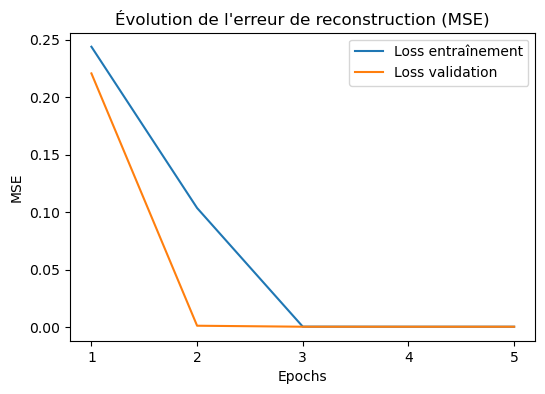

In [13]:
plt.figure(figsize=(6, 4))

epochs = range(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], label='Loss entraînement')
plt.plot(epochs, history.history['val_loss'], label='Loss validation')

plt.xticks(epochs)  # afficher chaque epoch sur l’axe X

plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title("Évolution de l'erreur de reconstruction (MSE)")
plt.legend()
plt.show()

In [14]:
# Projection dans l'espace latent (compression)

X_train_encoded = encoder.predict(X_train_dense)
X_test_encoded = encoder.predict(X_test_dense)

print("\nDimensions après compression :")
print("Train encodé :", X_train_encoded.shape)
print("Test encodé  :", X_test_encoded.shape)


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Dimensions après compression :
Train encodé : (4457, 128)
Test encodé  : (1115, 128)


In [15]:
# Visualisation pipeline complet :
# Texte original → Texte nettoyé → TF-IDF → Latent

from IPython.display import display

i = 456

# Texte nettoyé (prétraité)

print("=== Texte nettoyé ===")
print(X_train_text[i])
print()

# 1) TF-IDF — mots avec poids non nuls

print("=== TF-IDF 5000 dimensions (tokens non nuls) ===")

row_dense = X_train_tfidf[i].toarray()[0]
non_zero_idx = np.where(row_dense != 0)[0]
feature_names = vectorizer.get_feature_names_out()

df_tfidf = pd.DataFrame({
    "index": non_zero_idx,
    "token": feature_names[non_zero_idx],
    "tfidf": row_dense[non_zero_idx]
})

df_tfidf = df_tfidf.sort_values(by="tfidf", ascending=False)
display(df_tfidf.head(20))  # top 20

# 2) Représentation latente (128 dimensions)

print("\n=== Espace latent (128 dimensions) ===")

row_latent = X_train_encoded[i]
df_latent = pd.DataFrame(row_latent.reshape(1, -1), index=[i])
display(df_latent)  # 1 ligne × 128 colonnes

=== Texte nettoyé ===
even friend priest call

=== TF-IDF 5000 dimensions (tokens non nuls) ===


,index,token,tfidf
1,1092,even,0.656992
2,1345,friend,0.632736
0,352,call,0.409887



=== Espace latent (128 dimensions) ===


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
456,0.55579,0.483491,0.610638,0.734393,0.0,0.764887,0.0,0.534602,0.128812,0.837182,...,0.764177,0.74464,0.0,0.907351,0.466575,0.483498,0.94831,0.0,0.39727,0.704261


4. Comparer le modèle avec et sans sélection de caractéristiques

In [17]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

def eval_model(y_true, y_pred, model_name):
    print(f"  \033[1m{model_name}\033[0m\n  ") 
    
    # 1. Matrice de Confusion: 
    cm = confusion_matrix(y_true, y_pred, labels=["ham", "spam"])
    df_cm = pd.DataFrame(
        cm, 
        index=["Réel : Ham", "Réel : Spam"], 
        columns=["Prédit : Ham", "Prédit : Spam"]
    )
    print("\n1.Matrice de Confusion:")
    display(df_cm)

    
    # 2. Rapport de Classification:
    rc_dict = classification_report(y_true, y_pred, target_names=["ham", "spam"], output_dict=True) # sortie en tant que dictionnaire 
    df_rc = pd.DataFrame(rc_dict).transpose() # transposer le rapport pour avoir les métriques en colonnes  
    print("\n\n2.Rapport de Classification:")
    display(df_rc)

    # 3. Métriques scalaires arrondies pour simplifier:
    metrics = {
        "Modèle": model_name,
        "Accuracy": round(accuracy_score(y_true, y_pred), 3),
        "Precision (Spam)": round(precision_score(y_true, y_pred, pos_label="spam"), 3),
        "Recall (Spam)": round(recall_score(y_true, y_pred, pos_label="spam"), 3),
        "F1-Score (Spam)": round(f1_score(y_true, y_pred, pos_label="spam"), 3)
    }
    
    # Affichage en DataFrame à une seule ligne:
    df_metrics = pd.DataFrame([metrics])
    print(f"\n\n\033[1m3.Résumé de la {model_name}:\n")
    display(df_metrics)
    
    return metrics

# Liste pour stocker les résultats pour le tableau comparatif final:
results_list = []

In [18]:
# 2. Modèle 1 : Régression Logistique (TF-IDF Brut):

print("\nEntraînement sur TF-IDF complet:")
clf_raw = LogisticRegression(max_iter=1000, random_state=42)
clf_raw.fit(X_train_tfidf, y_train) # Entraînement sur TF-IDF complet
y_pred_raw = clf_raw.predict(X_test_tfidf)

# Évaluation et stockage:
res_raw = eval_model(y_test, y_pred_raw, model_name="Régression Logistique (TF-IDF Brut)")
results_list.append(res_raw)


Entraînement sur TF-IDF complet:
  Régression Logistique (TF-IDF Brut)
  

1.Matrice de Confusion:


,Prédit : Ham,Prédit : Spam
Réel : Ham,966,0
Réel : Spam,30,119




2.Rapport de Classification:


,precision,recall,f1-score,support
ham,0.969880,1.000000,0.984709,966.000000
spam,1.000000,0.798658,0.888060,149.000000
accuracy,0.973094,0.973094,0.973094,0.973094
macro avg,0.984940,0.899329,0.936385,1115.000000
weighted avg,0.973905,0.973094,0.971794,1115.000000




3.Résumé de la Régression Logistique (TF-IDF Brut):



,Modèle,Accuracy,Precision (Spam),Recall (Spam),F1-Score (Spam)
0,Régression Logistique (TF-IDF Brut),0.973,1.0,0.799,0.888


In [19]:
# 3. Modèle 2 : Régression Logistique (Autoencodeur):

print("\nEntraînement sur l'espace latent (Autoencodeur):")
#  class_weight='balanced' est utile car les données sont déséquilibrées après compression:
clf_encoded = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf_encoded.fit(X_train_encoded, y_train) # Entraînement sur l'espace latent
y_pred_encoded = clf_encoded.predict(X_test_encoded)

# Évaluation et stockage:
res_encoded = eval_model(y_test, y_pred_encoded, model_name="Régression Logistique (Autoencodeur)")
results_list.append(res_encoded)


Entraînement sur l'espace latent (Autoencodeur):
  Régression Logistique (Autoencodeur)
  

1.Matrice de Confusion:


,Prédit : Ham,Prédit : Spam
Réel : Ham,790,176
Réel : Spam,27,122




2.Rapport de Classification:


,precision,recall,f1-score,support
ham,0.966952,0.817805,0.886147,966.000000
spam,0.409396,0.818792,0.545861,149.000000
accuracy,0.817937,0.817937,0.817937,0.817937
macro avg,0.688174,0.818299,0.716004,1115.000000
weighted avg,0.892445,0.817937,0.840674,1115.000000




3.Résumé de la Régression Logistique (Autoencodeur):



,Modèle,Accuracy,Precision (Spam),Recall (Spam),F1-Score (Spam)
0,Régression Logistique (Autoencodeur),0.818,0.409,0.819,0.546


In [20]:
# 4. Comparaison Finale:
print("\nTableau comparatif des performances:")

df_results = pd.DataFrame(results_list)
df_results.set_index("Modèle", inplace=True)

# Affichage du tableau:
display(df_results)

# Analyse rapide du Delta (Différence de Recall):
delta_recall = res_encoded['Recall (Spam)'] - res_raw['Recall (Spam)'] # pour Spam qui nous intéressent
print(f"\nDelta Recall (Autoencodeur vs Brut) : {delta_recall:+.2f}")


Tableau comparatif des performances:


,Accuracy,Precision (Spam),Recall (Spam),F1-Score (Spam)
Modèle,,,,
Régression Logistique (TF-IDF Brut),0.973,1.000,0.799,0.888
Régression Logistique (Autoencodeur),0.818,0.409,0.819,0.546



Delta Recall (Autoencodeur vs Brut) : +0.02


5. Utiliser la Cross-Validation pour une évaluation robuste


In [21]:
def evaluate_with_cv(X_train, y_train, model_name, C=1.0, class_weight=None, penalty='l2', solver='lbfgs'):
    """
    Évalue un modèle avec Cross-Validation (5-fold stratifié)
    """
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    clf = LogisticRegression(
        max_iter=1000, 
        random_state=42, 
        C=C, 
        class_weight=class_weight,
        penalty=penalty,
        solver=solver
    )
    
    # Scorers personnalisés
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, pos_label='spam', zero_division=0),
        'recall': make_scorer(recall_score, pos_label='spam', zero_division=0),
        'f1': make_scorer(f1_score, pos_label='spam', zero_division=0)
    }
    
    # Cross-validation
    results = {}
    for metric_name, scorer in scoring.items():
        scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=scorer, n_jobs=-1)
        results[metric_name] = {
            'mean': scores.mean(),
            'std': scores.std()
        }
    
    # Affichage
    print(f"\n{model_name}:")
    print(f"  (Params: C={C}, Penalty='{penalty}', Solver='{solver}')")
    print(f"  Accuracy:  {results['accuracy']['mean']:.4f} (±{results['accuracy']['std']:.4f})")
    print(f"  Precision: {results['precision']['mean']:.4f} (±{results['precision']['std']:.4f})")
    print(f"  Recall:    {results['recall']['mean']:.4f} (±{results['recall']['std']:.4f})")
    print(f"  F1-Score:  {results['f1']['mean']:.4f} (±{results['f1']['std']:.4f})")
    
    return results

In [22]:
# OPTIMISATION AVEC GRIDSEARCH

print("##  Optimisation des Hyperparamètres avec GridSearchCV ##\n")

# Configuration CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_spam = make_scorer(f1_score, pos_label='spam')

    # GridSearch pour Autoencodeur
clf_base = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

grid_search_ae = GridSearchCV(
    estimator=clf_base, 
    param_grid=param_grid, 
    scoring=f1_spam,
    cv=cv,
    refit=True, 
    verbose=1, 
    n_jobs=-1
)

grid_search_ae.fit(X_train_encoded, y_train)

# Extraction des meilleurs paramètres
best_params_ae = grid_search_ae.best_params_
best_C_ae = best_params_ae['C']
best_penalty_ae = best_params_ae['penalty']
best_solver_ae = best_params_ae['solver']

print(f"\n✓ Optimisation Autoencodeur terminée.")
print(f"  - Meilleurs paramètres: C={best_C_ae}, Penalty={best_penalty_ae}, Solver={best_solver_ae}")
print(f"  - Meilleur F1-Score CV: {grid_search_ae.best_score_:.4f}")

# Évaluation avec les meilleurs paramètres
results_ae_optimized = evaluate_with_cv(
    X_train_encoded, y_train, 
    f"Autoencodeur ({X_train_encoded.shape[1]} features) - OPTIMISÉ",
    C=best_C_ae,
    class_weight='balanced',
    penalty=best_penalty_ae,
    solver=best_solver_ae
)

# Évaluation TF-IDF Brut (référence)
results_tfidf_balanced = evaluate_with_cv(
    X_train_tfidf, y_train, 
    "TF-IDF Brut (5000 features) - BALANCED", 
    class_weight='balanced'
)

##  Optimisation des Hyperparamètres avec GridSearchCV ##

Fitting 5 folds for each of 8 candidates, totalling 40 fits

✓ Optimisation Autoencodeur terminée.
  - Meilleurs paramètres: C=100, Penalty=l2, Solver=lbfgs
  - Meilleur F1-Score CV: 0.6370

Autoencodeur (128 features) - OPTIMISÉ:
  (Params: C=100, Penalty='l2', Solver='lbfgs')
  Accuracy:  0.8721 (±0.0056)
  Precision: 0.5146 (±0.0134)
  Recall:    0.8361 (±0.0117)
  F1-Score:  0.6370 (±0.0125)

TF-IDF Brut (5000 features) - BALANCED:
  (Params: C=1.0, Penalty='l2', Solver='lbfgs')
  Accuracy:  0.9791 (±0.0038)
  Precision: 0.9205 (±0.0206)
  Recall:    0.9247 (±0.0143)
  F1-Score:  0.9225 (±0.0139)


In [23]:
# FONCTION D'ÉVALUATION FINALE

def evaluate_final_model(X_train, X_test, y_train, y_test, model_name, C=1.0, 
                        class_weight=None, penalty='l2', solver='lbfgs'):
    """
    Entraîne le modèle final et évalue sur le test set
    """
    clf = LogisticRegression(
        max_iter=1000, 
        random_state=42, 
        C=C, 
        class_weight=class_weight,
        penalty=penalty,
        solver=solver
    )
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(f"\n{model_name}:\n")
    print(f"(Params: C={C}, Penalty='{penalty}', Solver='{solver}')")
    
    print("\nMatrice de Confusion:")
    cm = confusion_matrix(y_test, y_pred, labels=["ham", "spam"])
    print(cm)
    
    print("\nRapport de Classification:")
    print(classification_report(y_test, y_pred, target_names=["ham", "spam"]))
    
    # Visualisation de la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["ham", "spam"], 
                yticklabels=["ham", "spam"])
    plt.title(f'Matrice de Confusion - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.tight_layout()
    
    # Sauvegarde
    filename = f"confusion_matrix_{model_name.replace(' ', '_').replace('(', '').replace(')', '')}.png"
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"\n✓ Matrice sauvegardée: '{filename}'")
    plt.show()
    
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, pos_label='spam'),
        'recall': recall_score(y_test, y_pred, pos_label='spam'),
        'f1': f1_score(y_test, y_pred, pos_label='spam')
    }



##  Résultats de l'Évaluation Finale sur le Test Set ##

Autoencodeur (OPTIMISÉ):

(Params: C=100, Penalty='l2', Solver='lbfgs')

Matrice de Confusion:
[[837 129]
 [ 27 122]]

Rapport de Classification:
              precision    recall  f1-score   support

         ham       0.97      0.87      0.91       966
        spam       0.49      0.82      0.61       149

    accuracy                           0.86      1115
   macro avg       0.73      0.84      0.76      1115
weighted avg       0.90      0.86      0.87      1115


✓ Matrice sauvegardée: 'confusion_matrix_Autoencodeur_OPTIMISÉ.png'


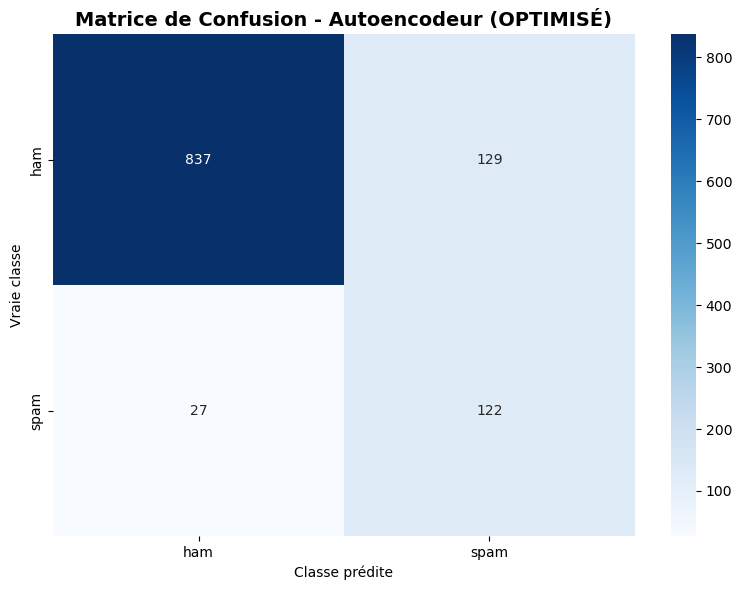


TF-IDF Brut (BALANCED):

(Params: C=1.0, Penalty='l2', Solver='lbfgs')

Matrice de Confusion:
[[957   9]
 [ 12 137]]

Rapport de Classification:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.94      0.92      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115


✓ Matrice sauvegardée: 'confusion_matrix_TF-IDF_Brut_BALANCED.png'


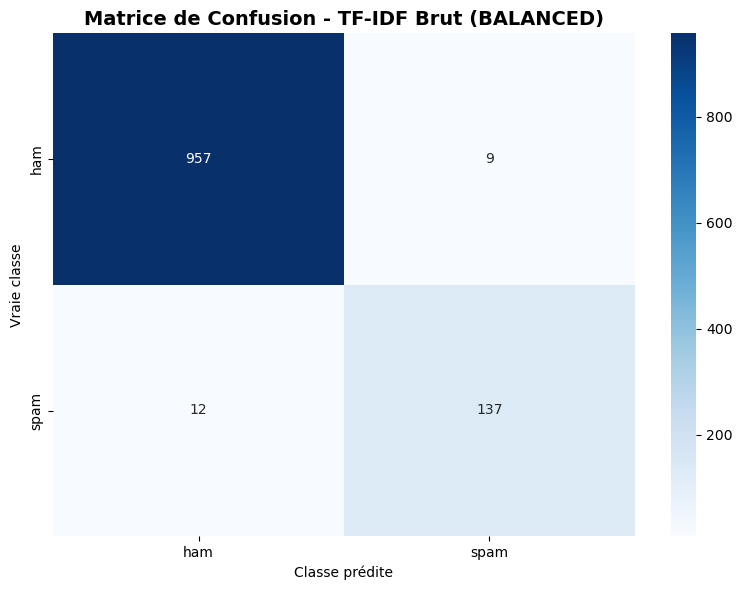

In [24]:
# ÉVALUATION FINALE SUR TEST SET

print("\n##  Résultats de l'Évaluation Finale sur le Test Set ##")

# 1. Autoencodeur optimisé
final_ae_optimized = evaluate_final_model(
    X_train_encoded, X_test_encoded, y_train, y_test, 
    "Autoencodeur (OPTIMISÉ)",
    C=best_C_ae, 
    class_weight='balanced',
    penalty=best_penalty_ae, 
    solver=best_solver_ae
)

# 2. TF-IDF Brut
final_tfidf_balanced = evaluate_final_model(
    X_train_tfidf, X_test_tfidf, y_train, y_test, 
    "TF-IDF Brut (BALANCED)",
    C=1.0, 
    class_weight='balanced'
)


6. Utilisation d'un modele pré entrainé (Bert)

In [26]:
# Utilisation d'un modèle pré-entraîné : BERT
#     (Feature extraction + Logistic Regression)
'''from transformers import AutoTokenizer, AutoModel
import torch
pretrained_model_name = "bert-base-uncased"

tokenizer_bert = AutoTokenizer.from_pretrained(pretrained_model_name)
bert_model = AutoModel.from_pretrained("bert-base-uncased")

def encode_texts_with_bert(texts, tokenizer, model, max_len=64):
    encodings = tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(**encodings)

    cls_embeddings = outputs.last_hidden_state[:, 0, :]

    return cls_embeddings.cpu().numpy()

print("\nExtraction des embeddings BERT… (cela peut prendre quelques minutes)")
X_train_bert = encode_texts_with_bert(X_train_text, tokenizer_bert, bert_model)
X_test_bert  = encode_texts_with_bert(X_test_text, tokenizer_bert, bert_model)

print("Shape embeddings BERT :")
print("Train :", X_train_bert.shape)
print("Test  :", X_test_bert.shape)

clf_bert = LogisticRegression(max_iter=1000)
clf_bert.fit(X_train_bert, y_train)
y_pred_bert = clf_bert.predict(X_test_bert)
"""

SyntaxError: incomplete input (3826119551.py, line 3)